# Exploratory Data Analysis for repo issues - Jest

In [1]:
from itertools import compress
import re
from collections import Counter
import json
import warnings

import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from utils.process_repo_issues import read_repo_issues_summary_data, process_texts, generate_wordcloud

%matplotlib inline

# Suppress pandas's warning
warnings.simplefilter(action='ignore', category=Warning)


In [2]:
csv_path = 'data/repo_issue_summary_jest.csv'
df_orig = read_repo_issues_summary_data(csv_path)

In [3]:
df_orig.head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
0,3,Make global `jest` command line tool like webp...,"webpack can be installed globally, but it dele...",sophiebits,CONTRIBUTOR,2014-05-14 17:17:25+00:00,True,2014-05-16 00:15:53+00:00,1.29,NaN,...,False,False,False,False,False,False,False,False,False,False
1,4,Have a mode to print out a line for each test ...,More fun that way (instead of just the filename).,sophiebits,CONTRIBUTOR,2014-05-14 17:26:17+00:00,True,2015-09-21 23:04:12+00:00,495.23,NaN,...,False,False,False,False,False,False,False,False,False,False
2,5,Use jasmine's `toHaveBeenCalled` rather than `...,13:23 jeffmo: what's the reason behind using ...,chenglou,CONTRIBUTOR,2014-05-14 17:26:37+00:00,True,2016-04-12 01:45:53+00:00,698.35,NaN,...,False,False,False,False,False,False,False,False,False,False
3,6,Expose a `--help`,,chenglou,CONTRIBUTOR,2014-05-14 17:56:10+00:00,True,2014-05-15 07:52:07+00:00,0.58,NaN,...,False,False,False,False,False,False,False,False,False,False
4,7,Add a `--watch`,,chenglou,CONTRIBUTOR,2014-05-14 17:57:45+00:00,True,2015-10-16 00:18:52+00:00,519.26,NaN,...,False,False,False,False,False,False,False,False,False,False


In [4]:
df_orig.shape

(4530, 51)

In [5]:
df_orig['labels'].apply(lambda x: len(x) > 0).sum()

1536

In [6]:
df_orig.groupby(['authorLogin', 'authorAssociation'])['issue_id'].count().sort_values(ascending=False)

authorLogin          authorAssociation
cpojer               CONTRIBUTOR          83
aaronabramov         MEMBER               69
gaearon              MEMBER               43
SimenB               COLLABORATOR         40
thymikee             COLLABORATOR         35
hramos               CONTRIBUTOR          30
kentcdodds           CONTRIBUTOR          25
probablyup           CONTRIBUTOR          21
rogeliog             COLLABORATOR         17
ide                  CONTRIBUTOR          16
hgezim               CONTRIBUTOR          14
Daniel15             MEMBER               14
dandv                CONTRIBUTOR          13
StephanBijzitter     CONTRIBUTOR          13
mjesun               CONTRIBUTOR          13
ColCh                CONTRIBUTOR          13
blainekasten         CONTRIBUTOR          12
binarykitchen        NONE                 12
segrey               NONE                 11
pedrottimark         COLLABORATOR         11
unional              NONE                 10
awei01          

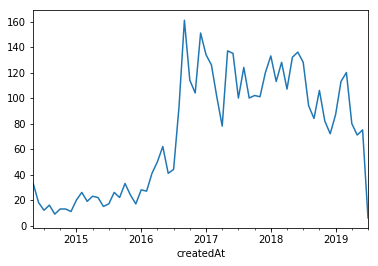

In [7]:
df_orig.groupby(pd.Grouper(key='createdAt', freq='M'))['issue_id'].count().plot();


In [8]:
all_cols = df_orig.columns.tolist()

# https://stackoverflow.com/questions/18665873/filtering-a-list-based-on-a-list-of-booleans
cols_labels = list(compress(all_cols, [x.startswith('label_') for x in all_cols]))

In [9]:
df_orig[cols_labels].sum().sort_values(ascending=False)

label_:bug: Bug                             346
label_Help Wanted                           292
label_:rocket: Feature Request              231
label_Needs Triage                          209
label_Needs Repro                           201
label_good first issue                      192
label_Bug Report                            178
label_:rocket: Enhancement                  144
label_Needs More Info :man_shrugging:       132
label_Documentation :book:                  118
label_Confirmed                             118
label_Discussion                             83
label_New API proposal                       42
label_Question                               41
label_Windows                                40
label_:boom: Regression                      37
label_Website                                15
label_Hi-Pri                                 14
label_UX                                     14
label_Wontfix                                 8
label_Infrastructure :hammer_and_wrench:

In [10]:
cols_label_bug = [
    'label_:bug: Bug',
    'label_Bug Report',
    'label_:boom: Regression',
    'label_Infrastructure :hammer_and_wrench:',
    'label_Upstream Bug',
]

df_label_bugs = df_orig[df_orig[cols_label_bug].sum(axis=1) > 0]


In [11]:
df_label_bugs.groupby(pd.Grouper(key='createdAt', freq='Y'))['issue_id'].count()

createdAt
2014-12-31 00:00:00+00:00      8
2015-12-31 00:00:00+00:00      2
2016-12-31 00:00:00+00:00     20
2017-12-31 00:00:00+00:00     61
2018-12-31 00:00:00+00:00    119
2019-12-31 00:00:00+00:00    360
Freq: A-DEC, Name: issue_id, dtype: int64

In [12]:
df_label_bugs.head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
64,102,Jest does not respect NODE_PATH,In our project we do not use any relative path...,iamrandys,NONE,2014-08-03 19:06:51+00:00,True,2015-02-19 22:19:17+00:00,200.13,NaN,...,False,False,False,False,False,False,False,False,True,False
67,106,modulePathIgnorePatterns does not work for nod...,When trying to configure node's util and event...,iamrandys,NONE,2014-08-05 18:11:02+00:00,True,2016-03-03 08:54:00+00:00,575.61,NaN,...,False,False,False,False,False,False,False,False,True,False
68,107,"Jest does not support jasmine ""Runner beforeEach""",beforeEach statements outside of describe stat...,iamrandys,NONE,2014-08-05 18:15:33+00:00,True,2015-11-19 00:12:02+00:00,470.25,NaN,...,False,False,False,False,False,False,False,False,True,False
72,112,Add possibility to define module directories.,"Using webpack and defining paths with the ""mod...",Chrazy,NONE,2014-08-07 06:31:21+00:00,True,2016-05-20 19:57:57+00:00,652.56,NaN,...,False,False,False,False,False,False,False,False,True,False
73,114,Preprocessor + coffee + source maps?,Hello guys. Thanks for making an awesome tool ...,gothy,NONE,2014-08-07 13:14:10+00:00,True,2015-10-16 00:35:00+00:00,434.47,NaN,...,False,False,False,False,False,False,False,False,True,False


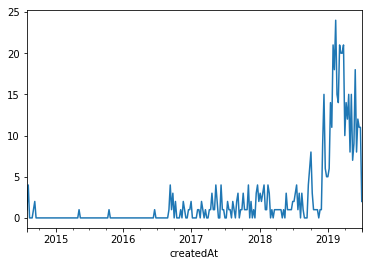

In [13]:
df_label_bugs.groupby(pd.Grouper(key='createdAt', freq='W'))['issue_id'].count().plot();


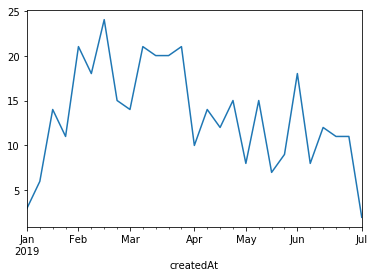

In [14]:
df_label_bugs[df_label_bugs['createdAt'] > '01-01-2019'].groupby(pd.Grouper(key='createdAt', freq='W'))['issue_id'].count().plot();


In [15]:
df_label_bugs[df_label_bugs['createdAt'] > '01-01-2019'].head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
3978,7572,jest > jest-cli > prompts > kleur@2.0.2: Pleas...,When installing (using Yarn) the following war...,basslagter,NONE,2019-01-03 13:45:14+00:00,True,2019-01-03 16:10:42+00:00,0.10,NaN,...,True,False,False,False,False,False,False,False,False,False
3979,7573,Bad interaction between using `jest.mock` retu...,🐛 Bug Report\nI use something like this in my ...,julienw,NONE,2019-01-03 15:54:36+00:00,False,NaT,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
3981,7578,File in node_modules not transformed (related ...,"🐛 Bug Report\nIn my jest config, I have the fo...",volkanunsal,NONE,2019-01-04 19:40:55+00:00,True,2019-01-05 17:27:55+00:00,0.91,NaN,...,False,False,False,False,False,False,False,False,True,False
3983,7584,babel-jest does not vary cache by babel version,🐛 Bug Report\nProject uses babel-jest and has ...,HavaH123,NONE,2019-01-07 10:58:04+00:00,False,NaT,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
3984,7586,`toStrictEqual` does not cover sparse arrays,I'm getting what I consider unexpected behavio...,marcfallows,CONTRIBUTOR,2019-01-08 01:28:02+00:00,True,2019-01-09 10:51:50+00:00,1.39,NaN,...,False,False,False,False,False,False,False,False,True,False


In [16]:
cols_feat_req = [
    'label_:rocket: Feature Request',
    'label_:rocket: Enhancement',
    'label_New API proposal',
]

df_label_feat = df_orig[df_orig[cols_feat_req].sum(axis=1) > 0]


In [17]:
df_label_feat.groupby(pd.Grouper(key='createdAt', freq='Y'))['issue_id'].count()

createdAt
2014-12-31 00:00:00+00:00      7
2015-12-31 00:00:00+00:00      1
2016-12-31 00:00:00+00:00     51
2017-12-31 00:00:00+00:00    125
2018-12-31 00:00:00+00:00    121
2019-12-31 00:00:00+00:00     96
Freq: A-DEC, Name: issue_id, dtype: int64

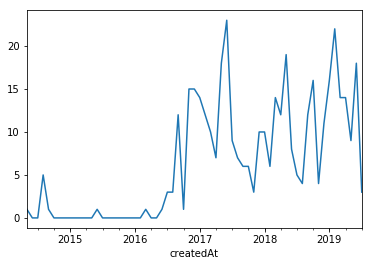

In [18]:
df_label_feat.groupby(pd.Grouper(key='createdAt', freq='M'))['issue_id'].count().plot();


### Comments data

In [19]:
# Load json data and create dataframe
json_path = 'data/github_repo_issues_jest.json'

with open(json_path) as json_file:  
    data_raw = json.load(json_file)

df_raw = pd.DataFrame.from_dict(data_raw)

In [20]:
df_all_texts = df_raw[['issue_id', 'createdAt', 'title', 'contents']]

In [21]:
df_all_texts['createdAt'] = pd.to_datetime(df_all_texts['createdAt'])

In [22]:
df_all_texts['comment_texts'] = df_raw['comments_data'].apply(lambda cur_col: ' '.join([x['contents'] for x in cur_col]))



In [23]:
df_all_texts.head()

,issue_id,createdAt,title,contents,comment_texts
0,3,2014-05-14 17:17:25+00:00,Make global `jest` command line tool like webp...,"webpack can be installed globally, but it dele...","We could also do the grunt-cli approach, which..."
1,4,2014-05-14 17:26:17+00:00,Have a mode to print out a line for each test ...,More fun that way (instead of just the filename).,I support this -- but it might be good to have...
2,5,2014-05-14 17:26:37+00:00,Use jasmine's `toHaveBeenCalled` rather than `...,13:23 jeffmo: what's the reason behind using ...,Thank you for reporting this issue and appreci...
3,6,2014-05-14 17:56:10+00:00,Expose a `--help`,,
4,7,2014-05-14 17:57:45+00:00,Add a `--watch`,,Thank you for reporting this issue and appreci...


In [24]:
df_all_texts_2_years = df_all_texts[df_all_texts['createdAt'] >= '01-01-2018']

In [25]:
df_all_texts_2_years.head()

,issue_id,createdAt,title,contents,comment_texts
2663,5202,2018-01-01 20:07:47+00:00,jest-snapshot does not work in browser,Do you want to request a feature or report a b...,I think this would be difficult without also s...
2664,5203,2018-01-02 00:02:54+00:00,teamcity coverage reporter,"Module\njest 22.0.4\n\n\nConfig\n\n\n""jest"": {...",How is this related to jest? If a teamcity rep...
2665,5204,2018-01-02 01:37:01+00:00,[bug] jest can't process ES6 modules with .mjs...,Do you want to request a feature or report a b...,duplicate of #4637 Thank you @Haroenv!
2666,5205,2018-01-02 03:24:08+00:00,Dynamically loaded modules crashing Jest,"When I run npm test on my project, it appears ...",This is not a Jest bug but an issue with your ...
2667,5206,2018-01-02 05:56:31+00:00,I can’t find expect() documentation in the API...,Do you want to request a feature or report a b...,"@ericnakagawa this is a docusaurus thing, righ..."


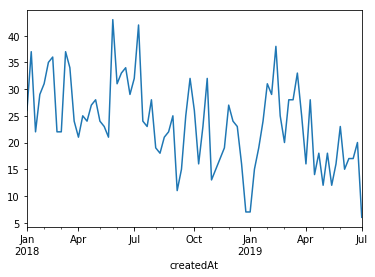

In [26]:
df_all_texts_2_years.groupby(pd.Grouper(key='createdAt', freq='W'))['issue_id'].count().plot();


In [27]:
df_all_texts_label_bugs = df_all_texts[df_all_texts['issue_id'].isin(df_label_bugs['issue_id'])]

In [28]:
df_all_texts_label_bugs.head()

,issue_id,createdAt,title,contents,comment_texts
64,102,2014-08-03 19:06:51+00:00,Jest does not respect NODE_PATH,In our project we do not use any relative path...,I'm also having an issue with this using webpa...
67,106,2014-08-05 18:11:02+00:00,modulePathIgnorePatterns does not work for nod...,When trying to configure node's util and event...,@iamrandys added a fix...expecting it to be te...
68,107,2014-08-05 18:15:33+00:00,"Jest does not support jasmine ""Runner beforeEach""",beforeEach statements outside of describe stat...,Thank you for reporting this issue and appreci...
72,112,2014-08-07 06:31:21+00:00,Add possibility to define module directories.,"Using webpack and defining paths with the ""mod...",👍 Another issue that I have:\nI use webpack.Re...
73,114,2014-08-07 13:14:10+00:00,Preprocessor + coffee + source maps?,Hello guys. Thanks for making an awesome tool ...,I would be very interested to see the sourcema...


In [29]:
df_all_texts_label_feat = df_all_texts[df_all_texts['issue_id'].isin(df_label_feat['issue_id'])]

## Word counts

### Steps:

1. Cleaning to remove irrelevant items, such as HTML tags
2. Normalizing by converting to all lowercase and removing punctuation
3. Splitting text into words or tokens
4. Removing words that are too common, also known as stop words
5. Identifying different parts of speech and named entities
6. Converting words into their dictionary forms, using stemming and lemmatization

In [30]:
# issue_text = (df_orig['title'] + ' ' + df_orig['contents']).tolist()
# issue_text = (df_orig['title']).tolist()

# issue_text = (df_label_bugs['title'] + ' ' + df_label_bugs['contents']).tolist()

# issue_text = (df_label_feat['title'] + ' ' + df_label_feat['contents']).tolist()


# issue_text = (df_all_texts['title'] + ' ' + df_all_texts['contents'] + ' ' + df_all_texts['comment_texts']).tolist()

# issue_text = (df_all_texts_label_bugs['title'] + ' ' + df_all_texts_label_bugs['contents'] + ' ' + df_all_texts_label_bugs['comment_texts']).tolist()

# issue_text = (df_all_texts_label_feat['title'] + ' ' + df_all_texts_label_feat['contents'] + ' ' + df_all_texts_label_feat['comment_texts']).tolist()

issue_text = (df_all_texts_2_years['title'] + ' ' + df_all_texts_2_years['contents'] + ' ' + df_all_texts_2_years['comment_texts']).tolist()
# issue_text = (df_all_texts_2_years['title'] + ' ' + df_all_texts_2_years['contents']).tolist()


#### 2. Normalization

In [31]:
# Example of template
# https://github.com/facebook/jest/issues/6138

jest_templates = [
    # Bug Report Template
    '🐛 Bug Report\n',
    'A clear and concise description of what the bug is.',
    'To Reproduce\n',
    'Steps to reproduce the behavior:',
    'Expected behavior\n',
    'A clear and concise description of what you expected to happen.',
    'Link to repl or repo (highly encouraged)\n',
    'Run npx envinfo --preset jest\n',
    'Paste the results here:\n',
    'Run npx envinfo --preset jest',
    'System:',
    'OS:',
    # Common OS info
    'x64',
    'Intel(R)',
    'Core(TM)',
    'CPU',
    'CPU:',
    
    'Binaries:',
    'Node:',
    '~/.nvm/versions/node/',
    '/bin/node',
    'nodejs',
    'node.EXE',
    'npm.CMD',
    'Yarn:',
    '/usr/local/bin/yarn',
    'versions',
    'npm:',
    '/bin/npm',
    'npmPackages',
    
    # Feature Proposal
    '🚀 Feature Proposal\n',
    'Example\n',
    'Pitch\n',
    
    # Regression
    '💥 Regression Report\n',
    'Last working version\n',
    'Worked up to version:',
    'Stopped working in version:',
    'To Reproduce\n',
    'Steps to reproduce the behavior:',
    'Expected behavior\n'
]

In [32]:
# Remove additional stopwords
additional_stopwords = [
    'jest',
    'test',
    'expect',
    'node',
    'npm',
    'yarn',
    
    'code',
    'const',
    'function',
    'import',
    'module',
    'new',
    'true',
    'false',
    'return',
    
    
    'pass',
    'fail',

    'chang',
    'doe',
    'did',
    'file',
    'http',
    'just',
    'js',
    'like',
    'link',
    'line',
    'issu',
    "n't",    
    'thank',
    'think',
    'total',
    'time',
    'resolv',
    'run',
    'use',    
    'using',
    'work',

]




In [33]:
custom_stopwords = {
    'before_process': jest_templates,
    'after_process': additional_stopwords
}

In [34]:
list_joined_text = process_texts(issue_text, custom_stopwords=custom_stopwords)

In [35]:
c_title_text = Counter(list_joined_text)
c_title_text.most_common(50)

[('error', 2224),
 ('bug', 1200),
 ('version', 1165),
 ('config', 1113),
 ('behavior', 1094),
 ('coverage', 1082),
 ('silly', 972),
 ('want', 931),
 ('require', 920),
 ('way', 888),
 ('project', 881),
 ('case', 847),
 ('babel', 838),
 ('savetree', 811),
 ('rootdir', 810),
 ('object', 807),
 ('sure', 806),
 ('need', 788),
 ('example', 770),
 ('feature', 769),
 ('add', 767),
 ('current', 742),
 ('problem', 741),
 ('mock', 730),
 ('provide', 719),
 ('help', 717),
 ('make', 711),
 ('repo', 689),
 ('async', 674),
 ('value', 670),
 ('watch', 669),
 ('configuration', 666),
 ('install', 652),
 ('pr', 651),
 ('simenb', 626),
 ('report', 624),
 ('snapshot', 617),
 ('default', 614),
 ('request', 591),
 ('suites', 584),
 ('fix', 579),
 ('string', 579),
 ('set', 577),
 ('suite', 571),
 ('undefined', 566),
 ('promise', 544),
 ('instead', 542),
 ('option', 537),
 ('console.log', 534),
 ('following', 531)]

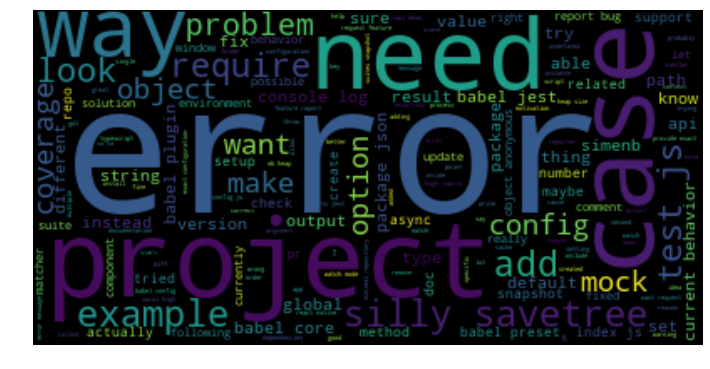

In [36]:
# Generate a word cloud image

generate_wordcloud(list_joined_text)

## EDA issues in the pass 2 years


In [39]:
df_2_years = df_orig[df_orig['createdAt'] >= '01-01-2018']

In [40]:
df_2_years.columns

Index(['issue_id', 'title', 'contents', 'authorLogin', 'authorAssociation',
       'createdAt', 'closed', 'closedAt', 'closedDuration_days', 'milestone',
       'participants_count', 'comments_count', 'firstCommentCreatedAt',
       'firstCommentDuration_days', 'firstCommentAuthor',
       'firstCommentAuthorAssociation', 'num_unique_comment_author_MEMBER',
       'num_unique_comment_author_CONTRIBUTOR',
       'num_unique_comment_author_COLLABORATOR',
       'num_unique_comment_author_NONE', 'labels',
       'label_Needs More Info :man_shrugging:',
       'label_:speech_balloon: Question', 'label_Website', 'label_Help Wanted',
       'label_Windows', 'label_Needs Repro', 'label_Area: Concurrent',
       'label_:rocket: Enhancement', 'label_Upstream Bug', 'label_Hi-Pri',
       'label_good first issue', 'label_Area: Crash', 'label_Duplicate',
       'label_New API proposal', 'label_UX', 'label_React Native',
       'label_Discussion', 'label_Infrastructure :hammer_and_wrench:',
       

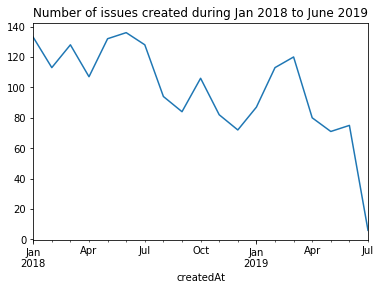

In [41]:
df_2_years.groupby(pd.Grouper(key='createdAt', freq='M'))['issue_id'].count().plot();
plt.title('Number of issues created during Jan 2018 to June 2019');

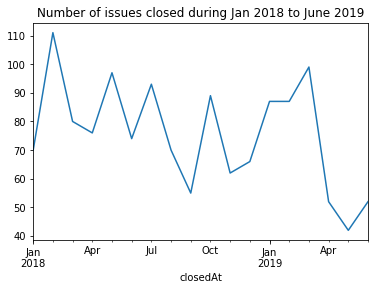

In [42]:
df_2_years.groupby(pd.Grouper(key='closedAt', freq='M'))['issue_id'].count().plot();
plt.title('Number of issues closed during Jan 2018 to June 2019');

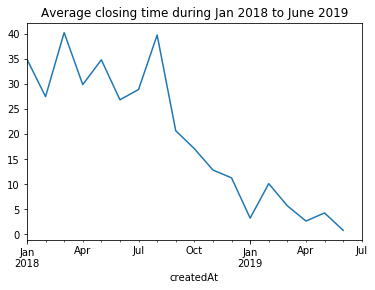

In [43]:
df_2_years.groupby(pd.Grouper(key='createdAt', freq='M'))['closedDuration_days'].mean().plot();
plt.title('Average closing time during Jan 2018 to June 2019');

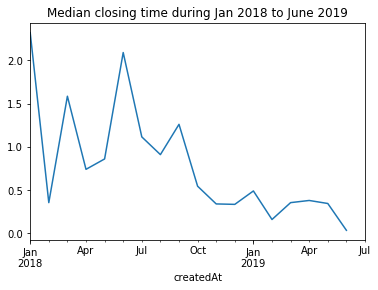

In [44]:
df_2_years.groupby(pd.Grouper(key='createdAt', freq='M'))['closedDuration_days'].median().plot();
plt.title('Median closing time during Jan 2018 to June 2019');

Look at issues which is closed within 3 days

In [45]:
df_closed_3_days = df_2_years[df_2_years['closedDuration_days'] <=3]

In [46]:
df_closed_3_days.shape

(904, 51)

In [47]:
df_closed_3_days[cols_labels].sum().sort_values(ascending=False)

label_:bug: Bug                             104
label_Needs Repro                            91
label_Needs Triage                           85
label_Bug Report                             83
label_Help Wanted                            35
label_:rocket: Feature Request               33
label_good first issue                       26
label_Needs More Info :man_shrugging:        24
label_Confirmed                              15
label_:boom: Regression                      15
label_Documentation :book:                   14
label_Question                               13
label_:rocket: Enhancement                    9
label_Discussion                              5
label_Wontfix                                 4
label_New API proposal                        4
label_Website                                 3
label_Hi-Pri                                  2
label_:speech_balloon: Question               1
label_Infrastructure :hammer_and_wrench:      1
label_Duplicate                         

In [48]:
cols_label_bug

['label_:bug: Bug',
 'label_Bug Report',
 'label_:boom: Regression',
 'label_Infrastructure :hammer_and_wrench:',
 'label_Upstream Bug']

In [49]:
df_closed_3_days_bugs = df_closed_3_days[df_closed_3_days[cols_label_bug].sum(axis=1) > 0]


In [50]:
df_closed_3_days_bugs.shape

(202, 51)

In [51]:
df_closed_3_days_bugs.head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
2723,5305,"Missing newline after ""no files changed""","I see this in Jest 22.0.6:\n\nTo reproduce, yo...",gaearon,MEMBER,2018-01-14 13:40:56+00:00,True,2018-01-14 20:10:34+00:00,0.27,NaN,...,False,False,False,False,False,False,True,False,True,False
2750,5361,rejects/resolves does not fail the test on non...,Do you want to request a feature or report a b...,alexilyaev,CONTRIBUTOR,2018-01-22 13:14:29+00:00,True,2018-01-24 16:55:39+00:00,2.15,NaN,...,False,False,False,False,False,False,True,False,True,False
2872,5591,AppVeyor doesn't run eslint,What is the current behavior?\nAppVeyor build ...,olfilato,NONE,2018-02-16 23:34:01+00:00,True,2018-02-19 21:18:42+00:00,2.91,NaN,...,False,False,False,False,False,False,False,False,False,False
3242,6268,"Using ""expect.not.stringContaining"" produces a...",🐛 Bug Report\nThe example from the documentati...,sangaline,NONE,2018-05-25 19:31:13+00:00,True,2018-05-27 00:28:05+00:00,1.21,NaN,...,False,False,False,False,False,False,True,False,True,False
3481,6704,`toMatchInlineSnapshot` does not clear existin...,🐛 Bug Report\nA clear and concise description ...,SimenB,COLLABORATOR,2018-07-17 08:28:39+00:00,True,2018-07-19 11:28:09+00:00,2.12,NaN,...,False,False,False,False,False,False,True,False,True,False


In [52]:
issue_text_3_days_bugs = (df_closed_3_days_bugs['title'] + ' ' + df_closed_3_days_bugs['contents']).tolist()


In [53]:
list_joined_text_3_days_bugs = process_texts(issue_text_3_days_bugs, custom_stopwords=custom_stopwords)

In [54]:
c_title_text = Counter(list_joined_text_3_days_bugs)
c_title_text.most_common(50)

[('error', 152),
 ('undefined', 91),
 ('coverage', 81),
 ('async', 76),
 ('macos', 71),
 ('version', 56),
 ('following', 53),
 ('message', 49),
 ('value', 48),
 ('install', 46),
 ('npx', 45),
 ('project', 45),
 ('string', 41),
 ('config', 41),
 ('anonymous', 41),
 ('verbose', 41),
 ('require', 40),
 ('typeerror', 38),
 ('snapshot', 38),
 ('babel-jest', 38),
 ('react', 37),
 ('suite', 37),
 ('err', 37),
 ('installed', 36),
 ('mock', 36),
 ('console.log', 36),
 ('property', 35),
 ('printobjectproperties', 35),
 ('printcomplexvalue', 34),
 ('rootdir', 34),
 ('object', 33),
 ('unexpected', 33),
 ('printer', 33),
 ('example', 32),
 ('linux', 32),
 ('bug', 31),
 ('received', 31),
 ('repo', 30),
 ('transform', 30),
 ('case', 30),
 ('array', 30),
 ('promise', 29),
 ('await', 28),
 ('package.json', 27),
 ('try', 27),
 ('number', 26),
 ('babel', 26),
 ('component', 26),
 ('reproduction', 26),
 ('stall', 26)]

In [55]:
df_closed_3_days_bugs['comments_count'].describe()

count    202.000000
mean       3.004950
std        3.658966
min        0.000000
25%        1.000000
50%        2.000000
75%        3.750000
max       36.000000
Name: comments_count, dtype: float64

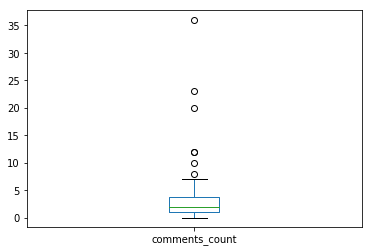

In [56]:
df_closed_3_days_bugs['comments_count'].plot.box();

In [57]:
df_closed_3_days_bugs[df_closed_3_days_bugs['comments_count'] <= 3].head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
3242,6268,"Using ""expect.not.stringContaining"" produces a...",🐛 Bug Report\nThe example from the documentati...,sangaline,NONE,2018-05-25 19:31:13+00:00,True,2018-05-27 00:28:05+00:00,1.21,NaN,...,False,False,False,False,False,False,True,False,True,False
3481,6704,`toMatchInlineSnapshot` does not clear existin...,🐛 Bug Report\nA clear and concise description ...,SimenB,COLLABORATOR,2018-07-17 08:28:39+00:00,True,2018-07-19 11:28:09+00:00,2.12,NaN,...,False,False,False,False,False,False,True,False,True,False
3579,6849,`testEnvironmentOptions` for custom environmen...,💥 Regression Report\nUsing (jest-environment-e...,Hypnosphi,NONE,2018-08-15 16:40:08+00:00,True,2018-08-15 20:19:37+00:00,0.15,NaN,...,False,False,False,False,False,False,False,False,True,False
3680,7026,Message when using `changedSince` is wrong,"🐛 Bug Report\nWhen using changedSince, the mes...",SimenB,COLLABORATOR,2018-09-22 15:04:58+00:00,True,2018-09-23 06:40:00+00:00,0.65,NaN,...,False,False,False,False,False,False,False,False,True,False
3755,7143,--coverage flag causes babel error,🐛 Bug Report\nUsing jest --coverage throws a B...,de-ocampo,NONE,2018-10-11 18:05:13+00:00,True,2018-10-11 18:21:50+00:00,0.01,NaN,...,False,False,False,False,False,False,False,False,True,False


In [60]:

df_2_years.groupby(['authorLogin', 'authorAssociation'])['issue_id'].count().sort_values(ascending=False)

authorLogin          authorAssociation
SimenB               COLLABORATOR         20
gaearon              MEMBER               11
thymikee             COLLABORATOR         10
unional              NONE                 10
deser                NONE                  9
kentcdodds           CONTRIBUTOR           8
mattphillips         COLLABORATOR          8
jamietre             CONTRIBUTOR           7
JoshuaKGoldberg      CONTRIBUTOR           7
budarin              NONE                  7
rickhanlonii         MEMBER                7
reggi                NONE                  7
theneva              CONTRIBUTOR           7
Aghassi              CONTRIBUTOR           6
sirian               NONE                  6
aaronabramov         MEMBER                6
dandv                CONTRIBUTOR           6
chrisblossom         CONTRIBUTOR           6
manu-st              NONE                  5
dubzzz               CONTRIBUTOR           5
captbaritone         CONTRIBUTOR           5
medikoo         

In [59]:
df_2_years.head()

,issue_id,title,contents,authorLogin,authorAssociation,createdAt,closed,closedAt,closedDuration_days,milestone,...,label_:boom: Regression,label_Wontfix,label_On Hold,label_Has Bounty,label_Coverage,label_Bug Report,label_Confirmed,label_Documentation :book:,label_:bug: Bug,label_Needs Triage
2663,5202,jest-snapshot does not work in browser,Do you want to request a feature or report a b...,Mosho1,NONE,2018-01-01 20:07:47+00:00,True,2018-02-11 14:52:37+00:00,40.78,NaN,...,False,False,False,False,False,False,False,False,False,False
2664,5203,teamcity coverage reporter,"Module\njest 22.0.4\n\n\nConfig\n\n\n""jest"": {...",wan54,NONE,2018-01-02 00:02:54+00:00,True,2018-02-11 14:50:07+00:00,40.62,NaN,...,False,False,False,False,False,False,False,False,False,False
2665,5204,[bug] jest can't process ES6 modules with .mjs...,Do you want to request a feature or report a b...,awidjaja,NONE,2018-01-02 01:37:01+00:00,True,2018-01-02 22:04:51+00:00,0.85,NaN,...,False,False,False,False,False,False,False,False,False,False
2666,5205,Dynamically loaded modules crashing Jest,"When I run npm test on my project, it appears ...",tylermurry,NONE,2018-01-02 03:24:08+00:00,True,2018-01-03 08:47:52+00:00,1.22,NaN,...,False,False,False,False,False,False,False,False,False,False
2667,5206,I can’t find expect() documentation in the API...,Do you want to request a feature or report a b...,binki,NONE,2018-01-02 05:56:31+00:00,True,2018-01-03 21:26:16+00:00,1.65,NaN,...,False,False,False,False,False,False,False,True,False,False


In [58]:
df_2_years['comments_count'].describe()

count    1867.000000
mean        4.531869
std         5.597085
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        69.000000
Name: comments_count, dtype: float64